In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import QuantileTransformer
# Wczytanie danych
df = pd.read_csv('./data/car_price_prediction.csv')
df.columns = [col.strip().replace(' ', '_').replace('.', '').lower() for col in df.columns]


In [45]:
# Preprocessing
df['leather_interior'] = df['leather_interior'].map({'Yes': 1, 'No': 0})
df['engine_volume'] = df['engine_volume'].astype(str).str.replace(' Turbo', '', regex=False).astype(float)
df['mileage'] = df['mileage'].astype(str).str.replace(' km', '', regex=False).str.replace(',', '').astype(int)
door_mapping = {
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '02-Mar': 2,
    '04-May': 4,
    'Other': 5,
    '>5': 5
}

df['doors'] = df['doors'].astype(str).map(door_mapping).fillna(5).astype(int)
df['levy'] = pd.to_numeric(df['levy'], errors='coerce').fillna(0)

df = df[df['price'] < df['price'].quantile(0.99)]

categorical = ['manufacturer', 'model', 'category', 'fuel_type', 'gear_box_type', 'drive_wheels', 'wheel', 'color']
df = pd.get_dummies(df, columns=categorical, drop_first=True)

df.drop(['id'], axis=1, inplace=True)


In [46]:
#usuwanie outlierów z iqr
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

numeric_cols = ['engine_volume', 'mileage', 'levy', 'price']
df = remove_outliers_iqr(df, numeric_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16221 entries, 0 to 19236
Columns: 1655 entries, price to color_Yellow
dtypes: bool(1646), float64(3), int64(6)
memory usage: 26.7 MB


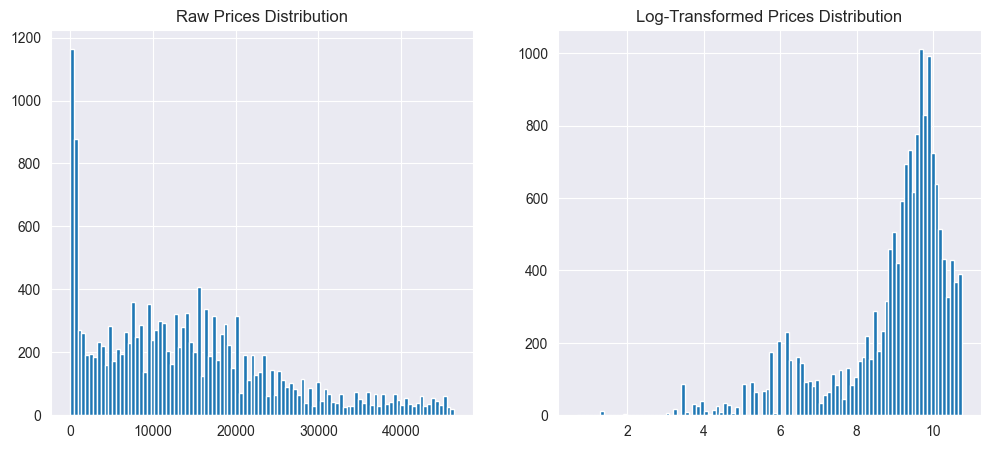

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100)
plt.title("Raw Prices Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100)
plt.title("Log-Transformed Prices Distribution")
plt.show()


In [62]:
X = df.drop('price', axis=1)
# Zmiana logarytmiczna celu
# y = np.log1p(df['price'])
#Transformacja danych na rozkład normalny
qt = QuantileTransformer(output_distribution='normal')
y = qt.fit_transform(df[['price']]).flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


C:\Users\Belucha\PycharmProjects\eksploracja\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,161 (860.00 KB)

 Trainable params: 220,161 (860.00 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:

# Gorsze wyniki
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    # callbacks=[early_stop, reduce_lr],
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2656 - val_loss: 0.7367
Epoch 2/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7583 - val_loss: 0.6491
Epoch 3/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6159 - val_loss: 0.5841
Epoch 4/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5392 - val_loss: 0.5482
Epoch 5/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4948 - val_loss: 0.5089
Epoch 6/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4520 - val_loss: 0.5006
Epoch 7/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4461 - val_loss: 0.4744
Epoch 8/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4203 - val_loss: 0.4652
Epoch 9/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3966 - val_loss: 0.4662
Epoch 10/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3717 - val_loss: 0.4543
Epoch 11/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3830 - val_loss: 0.4467
Epoch 12/200
163/163 ━━━━━━━━━━━━━━━━━━━━

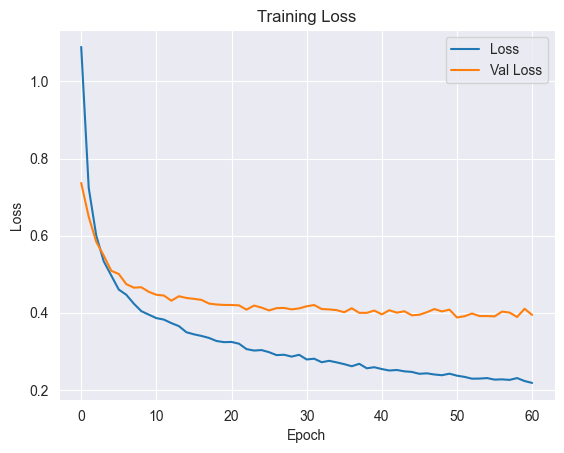

In [51]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [59]:
# Predykcja i ponowna transformacja wyniku
# y_pred = model.predict(X_test_scaled).flatten()
# y_pred = np.expm1(y_pred)
# y_true = np.expm1(y_test)
y_pred = model.predict(X_test_scaled).flatten()
y_true = qt.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = qt.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Wyniki modelu
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
r2 = r2_score(y_true, y_pred)
print(f'R^2: {r2:.4f}')
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape:.2f}%')

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
RMSE: 6441.93
MAE: 4120.87
R^2: 0.6839
MAPE: 1020.32%


C:\Users\Belucha\PycharmProjects\eksploracja\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
C:\Users\Belucha\PycharmProjects\eksploracja\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


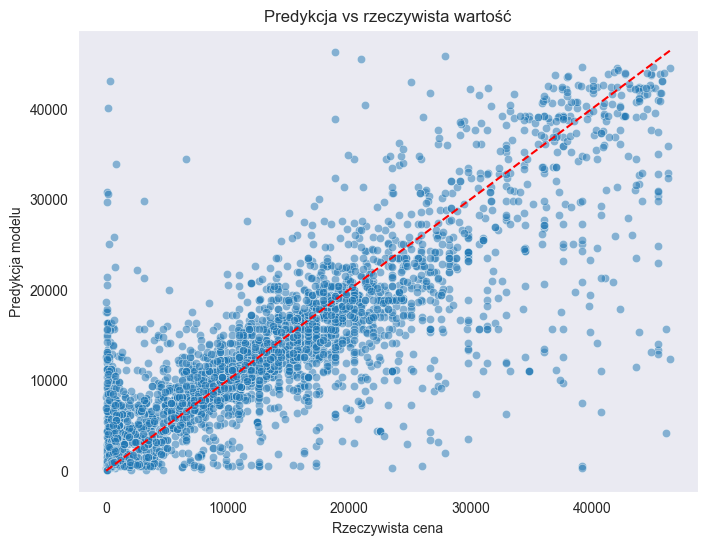

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykcja modelu")
plt.title("Predykcja vs rzeczywista wartość")
plt.grid()
plt.show()

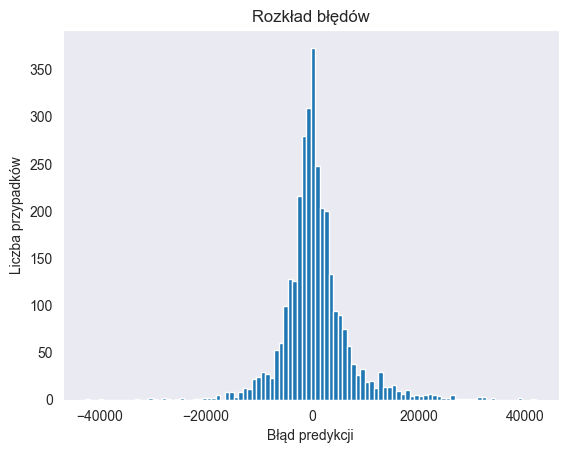

In [61]:
residuals = y_true - y_pred
plt.hist(residuals, bins=100)
plt.title("Rozkład błędów")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba przypadków")
plt.grid()
plt.show()